In [ ]:
from zipfile import ZipFile
filename = "dataset.zip"

with ZipFile(filename, 'r') as zip:
  zip.extractall()


In [1]:
import numpy as np
import os
import imutils
import cv2
from imutils import paths
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils


base_dir = "dataset"
data = []
labels = []
max_negatives = 4000
total_negatives = 0

for image_folder in sorted(list(paths.list_images(base_dir))):
    image = cv2.imread(image_folder)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #print("Type(image) = ", type(image))
    image = img_to_array(image)
    #print("Entry")
    #print(image_folder)
    #print(image_folder.split('/')[1])
    corresponding_label = image_folder.split('/')[1]
    if(corresponding_label == "positives7"):
        data.append(image/255.0)
        labels.append("smile")
    elif corresponding_label == "negatives7" and total_negatives < max_negatives:
        total_negatives += 1
        data.append(image/255.0)
        labels.append("no_smile")
print(total_negatives)
data = np.array(data)
labels = np.array(labels)
lab_enc = LabelEncoder().fit(labels)
labels = np_utils.to_categorical(lab_enc.transform(labels), 2)


Using TensorFlow backend.
4000


In [2]:
from sklearn.model_selection import train_test_split

(train_x, test_x, train_y, test_y) = train_test_split(data, labels,
    test_size = 0.20, stratify = labels, random_state = 42, shuffle=True)
print("Done")


Done


In [3]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense, Dropout
from keras.layers import BatchNormalization


In [4]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding = "same", activation="relu"))
model.add(MaxPooling2D((2, 2),strides=(2,2)))
model.add(Conv2D(128, (5, 5), padding = "same", activation="relu"))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(512, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(2, activation="softmax"))
print("Done")

Done


In [5]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
print("Done")

Done


In [6]:
batch_size=64
history = model.fit(train_x, train_y, validation_data = (test_x, test_y), batch_size=batch_size, epochs = 10)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 6152 samples, validate on 1538 samples
Epoch 1/10
6152/6152 [==============================] - 124s 20ms/step - loss: 0.4861 - accuracy: 0.7875 - val_loss: 0.6610 - val_accuracy: 0.6216
Epoch 2/10
6152/6152 [==============================] - 128s 21ms/step - loss: 0.3228 - accuracy: 0.8695 - val_loss: 0.4034 - val_accuracy: 0.8667
Epoch 3/10
6152/6152 [==============================] - 125s 20ms/step - loss: 0.2794 - accuracy: 0.8877 - val_loss: 0.4523 - val_accuracy: 0.7939
Epoch 4/10
6152/6152 [==============================] - 127s 21ms/step - loss: 0.2646 - accuracy: 0.8955 - val_loss: 0.3030 - val_accuracy: 0.8615
Epoch 5/10
6152/6152 [==============================] - 122s 20ms/step - loss: 0.2547 - accuracy: 0.8991 - val_loss: 0.5084 - val_accuracy: 0.7523
Epoch 6/10
6152/6152 [==============================] - 123s 20ms/step - loss: 0.2221 - accuracy: 0.9119 - val_loss: 0.28

In [7]:
from sklearn.metrics import classification_report

print("[INFO] training network...")
predictions = model.predict(test_x, batch_size = 64)
print(classification_report(test_y.argmax(axis = 1),
    predictions.argmax(axis = 1), target_names = lab_enc.classes_))


[INFO] training network...
              precision    recall  f1-score   support

    no_smile       0.93      0.88      0.90       800
       smile       0.87      0.92      0.90       738

   micro avg       0.90      0.90      0.90      1538
   macro avg       0.90      0.90      0.90      1538
weighted avg       0.90      0.90      0.90      1538



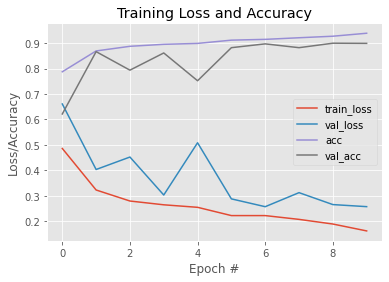

In [8]:
import matplotlib.pyplot as plt

# plot the training + testing loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 10), history.history["loss"], label = "train_loss")
plt.plot(np.arange(0, 10), history.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0, 10), history.history["accuracy"], label = "acc")
plt.plot(np.arange(0, 10), history.history["val_accuracy"], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("Curve")
plt.show()

In [9]:
model.save("Output2.hdf5")